# Try some simple bagging & boosting method

In [70]:
#import packages, load data
import numpy as np
import pandas as pd
import sklearn
import lightgbm as lgb
import talib as tb
import tensorflow as tf
import matplotlib.pyplot as plt

In [71]:
#CSI300 index data
df = pd.read_csv('../data/000300.csv')

#add label column, 1:up/-1:down
df['label'] = 0
for i in range(len(df) - 1):
    if df.loc[i + 1]['close'] >= df.loc[i]['close']:
        df.loc[i, 'label'] = 1
    else:
        df.loc[i, 'label'] = -1
df.loc[len(df) - 1, 'label'] = 1

print(df.shape)
df.head(20)

(2507, 8)


,date,open,close,high,low,total_turnover,volume,label
0,2007-04-02,2793.9570,2850.1069,2850.1521,2793.9570,7.668051e+10,6.924788e+09,1
1,2007-04-03,2861.8979,2888.1150,2888.3291,2852.5710,8.709185e+10,7.701450e+09,1
2,2007-04-04,2893.3770,2911.8210,2924.6760,2875.6851,8.845607e+10,7.550666e+09,1
3,2007-04-05,2909.5000,2945.0449,2950.6589,2895.4160,8.519560e+10,7.413899e+09,1
4,2007-04-06,2921.7271,2972.0081,2977.4590,2911.0520,9.304957e+10,7.910233e+09,1
5,2007-04-09,2988.3770,3038.1721,3043.0601,2988.3770,1.062188e+11,9.090170e+09,1
6,2007-04-10,3053.3550,3081.5681,3081.6169,2993.1140,1.197022e+11,1.008883e+10,1
7,2007-04-11,3092.0850,3121.3191,3121.5371,3059.2830,1.242189e+11,1.016699e+10,1
8,2007-04-12,3129.2471,3176.4370,3176.6899,3114.9109,1.184341e+11,9.253519e+09,-1
9,2007-04-13,3182.7771,3169.2329,3211.6069,3154.1060,1.297284e+11,1.006531e+10,1


 1    1325
-1    1182
Name: label, dtype: int64


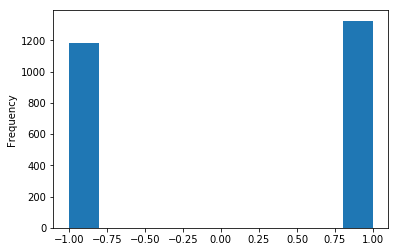

In [72]:
#plot the distribution of labels
print(df['label'].value_counts())
df['label'].astype(int).plot.hist()

## Add some features

This time let's compute all common technical indicators then choose some as features.

In [73]:
#ma12, ma26, ma60 and some feature cross
ma12 = tb.EMA(np.array(df['close']), timeperiod = 12)
ma26 = tb.EMA(np.array(df['close']), timeperiod = 26)
ma60 = tb.EMA(np.array(df['close']), timeperiod = 60)

ma12_ma26 = (ma12 > ma26).astype(int)
ma26_ma60 = (ma26 > ma60).astype(int)
ma12_ma26_ma60 = np.bitwise_and(ma12_ma26, ma26_ma60)
ma60_ma26_ma12 = np.bitwise_and(ma12 < ma26, ma26 < ma60).astype(int)

df.insert(len(df.columns), 'ma12', ma12)
df.insert(len(df.columns), 'ma26', ma26)
df.insert(len(df.columns), 'ma60', ma60)
df.insert(len(df.columns), 'ma12>ma26', ma12_ma26)
df.insert(len(df.columns), 'ma26>ma60', ma26_ma60)
df.insert(len(df.columns), 'ma12>ma26>ma60', ma12_ma26_ma60)
df.insert(len(df.columns), 'ma12<ma26<ma60', ma60_ma26_ma12)

df.head(100)

/usr/local/Cellar/ipython/6.3.1/libexec/vendor/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/usr/local/Cellar/ipython/6.3.1/libexec/vendor/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/usr/local/Cellar/ipython/6.3.1/libexec/vendor/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


,date,open,close,high,low,total_turnover,volume,label,ma12,ma26,ma60,ma12>ma26,ma26>ma60,ma12>ma26>ma60,ma12<ma26<ma60
0,2007-04-02,2793.9570,2850.1069,2850.1521,2793.9570,7.668051e+10,6.924788e+09,1,NaN,NaN,NaN,0,0,0,0
1,2007-04-03,2861.8979,2888.1150,2888.3291,2852.5710,8.709185e+10,7.701450e+09,1,NaN,NaN,NaN,0,0,0,0
2,2007-04-04,2893.3770,2911.8210,2924.6760,2875.6851,8.845607e+10,7.550666e+09,1,NaN,NaN,NaN,0,0,0,0
3,2007-04-05,2909.5000,2945.0449,2950.6589,2895.4160,8.519560e+10,7.413899e+09,1,NaN,NaN,NaN,0,0,0,0
4,2007-04-06,2921.7271,2972.0081,2977.4590,2911.0520,9.304957e+10,7.910233e+09,1,NaN,NaN,NaN,0,0,0,0
5,2007-04-09,2988.3770,3038.1721,3043.0601,2988.3770,1.062188e+11,9.090170e+09,1,NaN,NaN,NaN,0,0,0,0
6,2007-04-10,3053.3550,3081.5681,3081.6169,2993.1140,1.197022e+11,1.008883e+10,1,NaN,NaN,NaN,0,0,0,0
7,2007-04-11,3092.0850,3121.3191,3121.5371,3059.2830,1.242189e+11,1.016699e+10,1,NaN,NaN,NaN,0,0,0,0
8,2007-04-12,3129.2471,3176.4370,3176.6899,3114.9109,1.184341e+11,9.253519e+09,-1,NaN,NaN,NaN,0,0,0,0
9,2007-04-13,3182.7771,3169.2329,3211.6069,3154.1060,1.297284e+11,1.006531e+10,1,NaN,NaN,NaN,0,0,0,0


In [74]:
print(df['ma12>ma26'].value_counts())
print(df['ma26>ma60'].value_counts())
print(df['ma12>ma26>ma60'].value_counts())
print(df['ma12<ma26<ma60'].value_counts())

correlations = df.corr()['label'].sort_values()
print(correlations)

1    1290
0    1217
Name: ma12>ma26, dtype: int64
0    1327
1    1180
Name: ma26>ma60, dtype: int64
0    1539
1     968
Name: ma12>ma26>ma60, dtype: int64
0    1527
1     980
Name: ma12<ma26<ma60, dtype: int64
ma12<ma26<ma60   -0.039220
ma60              0.004967
ma26              0.017156
ma12              0.023750
low               0.028049
open              0.028534
close             0.029297
ma26>ma60         0.030971
high              0.031132
ma12>ma26         0.041903
total_turnover    0.045399
ma12>ma26>ma60    0.048241
volume            0.051976
label             1.000000
Name: label, dtype: float64


BOLL, SAR, MACD, StochRSI, RSI, DMI, OBV, TRIX, WR

In [75]:
#MACD
dif, dem, hist = tb.MACD(np.array(df['close']), fastperiod = 12, slowperiod = 26, signalperiod = 9)
df.insert(len(df.columns), 'macd_dif', dif)
df.insert(len(df.columns), 'macd_dem', dem)
df.insert(len(df.columns), 'macd_hist', hist)

#kdj
k, d = tb.STOCH(np.array(df['high']), np.array(df['low']), np.array(df['close']))
j = 3 * d - 2 * k
df.insert(len(df.columns), 'kdj_k', k)
df.insert(len(df.columns), 'kdj_d', d)
df.insert(len(df.columns), 'kdj_j', j)

#atr
atr = tb.ATR(np.array(df.high), np.array(df.low), np.array(df.close), timeperiod = 15)
df.insert(len(df.columns), 'atr', atr)
df.head(100)

,date,open,close,high,low,total_turnover,volume,label,ma12,ma26,...,ma26>ma60,ma12>ma26>ma60,ma12<ma26<ma60,macd_dif,macd_dem,macd_hist,kdj_k,kdj_d,kdj_j,atr
0,2007-04-02,2793.9570,2850.1069,2850.1521,2793.9570,7.668051e+10,6.924788e+09,1,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-04-03,2861.8979,2888.1150,2888.3291,2852.5710,8.709185e+10,7.701450e+09,1,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-04-04,2893.3770,2911.8210,2924.6760,2875.6851,8.845607e+10,7.550666e+09,1,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-04-05,2909.5000,2945.0449,2950.6589,2895.4160,8.519560e+10,7.413899e+09,1,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-04-06,2921.7271,2972.0081,2977.4590,2911.0520,9.304957e+10,7.910233e+09,1,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2007-04-09,2988.3770,3038.1721,3043.0601,2988.3770,1.062188e+11,9.090170e+09,1,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2007-04-10,3053.3550,3081.5681,3081.6169,2993.1140,1.197022e+11,1.008883e+10,1,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2007-04-11,3092.0850,3121.3191,3121.5371,3059.2830,1.242189e+11,1.016699e+10,1,NaN,NaN,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2007-04-12,3129.2471,3176.4370,3176.6899,3114.9109,1.184341e+11,9.253519e+09,-1,NaN,NaN,...,0,0,0,NaN,NaN,NaN,99.928230,99.059817,97.322990,NaN
9,2007-04-13,3182.7771,3169.2329,3211.6069,3154.1060,1.297284e+11,1.006531e+10,1,NaN,NaN,...,0,0,0,NaN,NaN,NaN,93.608721,97.547191,105.424132,NaN


In [76]:
#BOLL
up, mid, down = tb.BBANDS(np.array(df['close']), timeperiod=15, nbdevup=1, nbdevdn=1, matype=0)
df.insert(len(df.columns), 'boll_up', up)
df.insert(len(df.columns), 'boll_mid', mid)
df.insert(len(df.columns), 'boll_down', down)

#SAR
sar = tb.SAR(np.array(df['high']), np.array(df['low']))
sar[0] = sar[1]
df.insert(len(df.columns), 'sar', sar)

#RSI
rsi = tb.RSI(np.array(df['close']), timeperiod = 15)
df.insert(len(df.columns), 'rsi', rsi)

#StochRSI
fastk, fastd = tb.STOCHRSI(np.array(df['close']), timeperiod = 15, fastk_period = 5, fastd_period = 3, fastd_matype=0)
df.insert(len(df.columns), 'stochrsi_k', fastk)
df.insert(len(df.columns), 'stochrsi_d', fastd)

#DMI
dmi = tb.DX(np.array(df['high']), np.array(df['low']), np.array(df['close']), timeperiod = 15)
df.insert(len(df.columns), 'dmi', dmi)

#OBV
obv = tb.OBV(np.array(df['close']), np.array(df['volume']))
df.insert(len(df.columns), 'obv', obv)

#TRIX
trix = tb.TRIX(np.array(df['close']), timeperiod = 15)
df.insert(len(df.columns), 'trix', trix)

#WR
wr = tb.WILLR(np.array(df['high']), np.array(df['low']), np.array(df['close']), timeperiod = 15)
df.insert(len(df.columns), 'wr', wr)
df.head(100)

,date,open,close,high,low,total_turnover,volume,label,ma12,ma26,...,boll_mid,boll_down,sar,rsi,stochrsi_k,stochrsi_d,dmi,obv,trix,wr
0,2007-04-02,2793.9570,2850.1069,2850.1521,2793.9570,7.668051e+10,6.924788e+09,1,NaN,NaN,...,NaN,NaN,2793.957000,NaN,NaN,NaN,NaN,6.924788e+09,NaN,NaN
1,2007-04-03,2861.8979,2888.1150,2888.3291,2852.5710,8.709185e+10,7.701450e+09,1,NaN,NaN,...,NaN,NaN,2793.957000,NaN,NaN,NaN,NaN,1.462624e+10,NaN,NaN
2,2007-04-04,2893.3770,2911.8210,2924.6760,2875.6851,8.845607e+10,7.550666e+09,1,NaN,NaN,...,NaN,NaN,2795.844442,NaN,NaN,NaN,NaN,2.217690e+10,NaN,NaN
3,2007-04-05,2909.5000,2945.0449,2950.6589,2895.4160,8.519560e+10,7.413899e+09,1,NaN,NaN,...,NaN,NaN,2800.997704,NaN,NaN,NaN,NaN,2.959080e+10,NaN,NaN
4,2007-04-06,2921.7271,2972.0081,2977.4590,2911.0520,9.304957e+10,7.910233e+09,1,NaN,NaN,...,NaN,NaN,2809.977376,NaN,NaN,NaN,NaN,3.750104e+10,NaN,NaN
5,2007-04-09,2988.3770,3038.1721,3043.0601,2988.3770,1.062188e+11,9.090170e+09,1,NaN,NaN,...,NaN,NaN,2823.375906,NaN,NaN,NaN,NaN,4.659121e+10,NaN,NaN
6,2007-04-10,3053.3550,3081.5681,3081.6169,2993.1140,1.197022e+11,1.008883e+10,1,NaN,NaN,...,NaN,NaN,2845.344325,NaN,NaN,NaN,NaN,5.668004e+10,NaN,NaN
7,2007-04-11,3092.0850,3121.3191,3121.5371,3059.2830,1.242189e+11,1.016699e+10,1,NaN,NaN,...,NaN,NaN,2873.697034,NaN,NaN,NaN,NaN,6.684703e+10,NaN,NaN
8,2007-04-12,3129.2471,3176.4370,3176.6899,3114.9109,1.184341e+11,9.253519e+09,-1,NaN,NaN,...,NaN,NaN,2908.394644,NaN,NaN,NaN,NaN,7.610055e+10,NaN,NaN
9,2007-04-13,3182.7771,3169.2329,3211.6069,3154.1060,1.297284e+11,1.006531e+10,1,NaN,NaN,...,NaN,NaN,2951.321885,NaN,NaN,NaN,NaN,6.603524e+10,NaN,NaN


In [77]:
#one-hot encoding of label
df.insert(len(df.columns), 'up', 0)
df.insert(len(df.columns), 'down', 0)
for i in range(len(df)):
    if df.loc[i, 'label'] == 1:
        df.loc[i, 'up'] = 1
    elif df.loc[i, 'label'] == -1:
        df.loc[i, 'down'] = 1

feat_list = ['close', 'total_turnover', 'volume', 'ma12', 'ma26', 'ma60', 'ma12>ma26'\
            , 'ma26>ma60', 'ma12>ma26>ma60', 'ma12<ma26<ma60', 'macd_dif', 'macd_dem'\
            , 'macd_hist', 'kdj_k', 'kdj_d', 'kdj_j', 'atr', 'boll_up', 'boll_mid', \
             'boll_down', 'sar', 'rsi', 'stochrsi_k', 'stochrsi_d', 'dmi', 'obv', 'trix'\
            , 'wr']
label_list = ['up', 'down']

#normalization
def norm(df):
    for col in feat_list:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

norm(df)
df.head(100)

,date,open,close,high,low,total_turnover,volume,label,ma12,ma26,...,sar,rsi,stochrsi_k,stochrsi_d,dmi,obv,trix,wr,up,down
0,2007-04-02,2793.9570,0.287649,2850.1521,2793.9570,0.065523,0.077187,1,NaN,NaN,...,0.277066,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,1,0
1,2007-04-03,2861.8979,0.296593,2888.3291,2852.5710,0.076670,0.088799,1,NaN,NaN,...,0.277066,NaN,NaN,NaN,NaN,0.002328,NaN,NaN,1,0
2,2007-04-04,2893.3770,0.302172,2924.6760,2875.6851,0.078131,0.086545,1,NaN,NaN,...,0.277507,NaN,NaN,NaN,NaN,0.004611,NaN,NaN,1,0
3,2007-04-05,2909.5000,0.309990,2950.6589,2895.4160,0.074640,0.084500,1,NaN,NaN,...,0.278709,NaN,NaN,NaN,NaN,0.006852,NaN,NaN,1,0
4,2007-04-06,2921.7271,0.316335,2977.4590,2911.0520,0.083049,0.091921,1,NaN,NaN,...,0.280805,NaN,NaN,NaN,NaN,0.009243,NaN,NaN,1,0
5,2007-04-09,2988.3770,0.331905,3043.0601,2988.3770,0.097148,0.109563,1,NaN,NaN,...,0.283932,NaN,NaN,NaN,NaN,0.011991,NaN,NaN,1,0
6,2007-04-10,3053.3550,0.342118,3081.6169,2993.1140,0.111584,0.124495,1,NaN,NaN,...,0.289058,NaN,NaN,NaN,NaN,0.015041,NaN,NaN,1,0
7,2007-04-11,3092.0850,0.351472,3121.5371,3059.2830,0.116420,0.125664,1,NaN,NaN,...,0.295675,NaN,NaN,NaN,NaN,0.018114,NaN,NaN,1,0
8,2007-04-12,3129.2471,0.364443,3176.6899,3114.9109,0.110227,0.112005,-1,NaN,NaN,...,0.303773,NaN,NaN,NaN,NaN,0.020911,NaN,NaN,0,1
9,2007-04-13,3182.7771,0.362747,3211.6069,3154.1060,0.122319,0.124143,1,NaN,NaN,...,0.313791,NaN,NaN,NaN,NaN,0.017869,NaN,NaN,1,0
